In [12]:
using LinearAlgebra
using Plots
using Test
using Printf

#####################################
# Méthodes Quasi-Newton implémentée #
#####################################
function BFGS(sₖ, yₖ, Hₖ, Bₖ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Hₖ = (I-ρₖ*sₖ*transpose(yₖ))*Hₖ*(I-ρₖ*yₖ*transpose(sₖ)) + ρₖ*sₖ*transpose(sₖ)
    Bₖ += -Bₖ*sₖ*transpose(sₖ)*Bₖ/(dot(sₖ, Bₖ*sₖ)) + yₖ*transpose(yₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-4
    @test norm(Bₖ*sₖ - yₖ) < 10e-4
    @test norm(Hₖ*Bₖ - I) < 10e-1
    return(Hₖ, Bₖ)
end

function DFP(sₖ, yₖ, Hₖ, Bₖ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Bₖ = (I-ρₖ*yₖ*transpose(sₖ))*Bₖ*(I-ρₖ*sₖ*transpose(yₖ)) + ρₖ*yₖ*transpose(yₖ)
    Hₖ += -Hₖ*yₖ*transpose(yₖ)*Hₖ/(dot(yₖ, Hₖ*yₖ)) + sₖ*transpose(sₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function SR1(sₖ, yₖ, Hₖ, Bₖ)
    b = yₖ - Bₖ*sₖ
    @test abs(dot(b, sₖ)) > 10e-6*norm(b)*norm(sₖ)
    Bₖ += b*transpose(b)/(dot(b, sₖ))
    h = sₖ - Hₖ*yₖ
    @test abs(dot(h, yₖ)) > 10e-6*norm(yₖ)*norm(h)
    Hₖ += h*transpose(h)/(dot(h, yₖ))
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

SR1 (generic function with 1 method)

In [13]:
# Un problème de minimisation sans contrainte est associé à une fonction, 
# son gradient et la matrice approchant la Hessienne
mutable struct problem
    fonction # Evaluation de la fonction
    gradient # Evaluation du gradient
    Hess # Evaluation de la Hessienne
end

In [14]:
function lineSearch(problem, x₀, Δ; mem = 5, affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true)
    # initialisation
    g = problem.gradient
    k = 0
    n = length(x₀)
    pₖ = zeros(n)
    sₖ = zeros(n)
    yₖ = zeros(n)
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    Hₖ, Bₖ = I, I
    B = problem.Hess(x₀)
    NormP = []
    F = [] 
    α = []
    G = []
    orthogo = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||B-Bₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        if(k != 0)
            Hₖ, Bₖ = update(sₖ, yₖ, Hₖ, Bₖ)
            dₖ = -Hₖ*gₖ # Direction de descente
            C = zeros(n, k+1)
            C[1:n, 1:k] = P
            P = C
            P[1:n, k+1] = dₖ/norm(dₖ)
            ### Calcul de la perte d'orthogonalité
            U = P'*B*P
            D = Diagonal(U[diagind(U)])
            for i = 1:(k+1)
                for j = 1:i
                    U[i, j] = 0
                end
            end
            S = inv(D + U)*U
            push!(orthogo, norm(S))  
        else
            dₖ = -gₖ # Direction de descente
            global P = dₖ/norm(dₖ)
        end 
        ρₖ = 1/dot(yₖ, sₖ)
        bₖ = g(dₖ) - b
        if(abs(dot(gₖ, dₖ)) < 10e-6*norm(gₖ)*norm(dₖ) && negCurvature)
            if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                αₖ = 2*Δ/norm(dₖ)
            else
                dₖ = -gₖ
                bₖ = g(dₖ) - b
                if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                    αₖ = 2*Δ/norm(dₖ)
                else
                    αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
                end
            end
        elseif(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(Bₖ - B), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ)  
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            push!(G, norm(gₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, F, α, G, orthogo)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k-1, F, α, G, orthogo)
end

lineSearch (generic function with 1 method)

In [15]:
function CG(problem, x₀, Δ; mem = 5, maxiter = 1000, ϵ = 10e-8, affichage = true, negCurvature = true)
    A = problem.Hess(x₀)
    rₖ = problem.gradient(x₀)
    n = length(x₀)
    pₖ = -rₖ
    βₖ = 0
    k = 0
    xₖ = x₀
    normP = []
    F = []
    α = []
    G = []
    orthogo = []
    if(affichage)
        @printf("%4s %9s %6s %9s %9s %9s %9s \n", "k", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "β")
    end
    while(norm(rₖ) > ϵ && k <= maxiter)
        if(k > 0)
            C = zeros(n, k+1)
            C[1:n, 1:k] = P
            P = C
            P[1:n, k+1] = pₖ/norm(pₖ)  
            ### Calcul de la perte d'orthogonalité
            U = P'*A*P
            D = Diagonal(U[diagind(U)])
            for i = 1:(k+1)
                for j = 1:i
                    U[i, j] = 0
                end
            end
            S = inv(D + U)*U
            push!(orthogo, norm(S))
        else
            global P = pₖ/norm(pₖ)
        end
        bₖ = A*pₖ
        if(dot(pₖ, bₖ) <= 10e-6*norm(pₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(rₖ, pₖ))/norm(pₖ)
        else
            αₖ = -dot(rₖ, pₖ)/dot(pₖ, bₖ)
        end
        push!(α, norm(αₖ))
        xₖ += αₖ*pₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(pₖ, rₖ), αₖ, problem.fonction(xₖ), norm(xₖ - x₀), norm(rₖ), βₖ)
        end
        if(norm(xₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            sₖ = αₖ*pₖ
            xₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||xₙ₋₁ + τ*αₖ*pₖ||² = Δ²
            # <=> (||xₙ₋₁||² - Δ²) + 2*τ*dot(xₙ₋₁, αₖ*pₖ) + τ²*||αₖ*pₖ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(xₖ, sₖ)
            c = dot(xₖ, xₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            xₖ += τ*sₖ
            push!(normP, norm(xₖ - x₀))
            push!(F, problem.fonction(xₖ))
            push!(G, norm(rₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(xₖ), "||p*|| = ", norm(xₖ - x₀)) 
            end
            return(xₖ - x₀, k, normP, F, α, G, orthogo)
        end
        rₖ = problem.gradient(xₖ)
        βₖ = dot(rₖ, bₖ)/dot(pₖ, bₖ)
        pₖ = -rₖ + βₖ*pₖ
        k += 1
        push!(F, problem.fonction(xₖ))
        push!(normP, norm(xₖ - x₀))
        push!(G, norm(rₖ))
    end
    return(xₖ - x₀, k-1, normP, F, α, G, orthogo)
end

CG (generic function with 1 method)

In [16]:
using LinearOperators

function LMlineSearch(problem, x₀, Δ; mem = 5, affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, scaling = false, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    n = length(x₀)
    pₖ = zeros(n)
    yₖ = zeros(n)
    sₖ = zeros(n)
    B = problem.Hess(x₀)
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    sᵩ = zeros(length(x₀))
    τᵩ = 0
    Hₖ = InverseLBFGSOperator(n, mem, scaling = scaling, diag_scaling = scaling)
    A = problem.Hess(x₀)
    NormP = []
    F = []
    α = []
    G = []
    orthogo = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        dₖ = -Hₖ*gₖ # Direction de descente
        if(k > 0)
            C = zeros(n, k+1)
            C[1:n, 1:k] = P
            P = C
            P[1:n, k+1] = dₖ/norm(dₖ)
            ### Calcul de la perte d'orthogonalité
            U = P'*A*P
            D = Diagonal(U[diagind(U)])
            for i = 1:(k+1)
                for j = 1:i
                    U[i, j] = 0
                end
            end
            S = inv(D + U)*U
            push!(orthogo, norm(S))
        else
            global P = dₖ/norm(dₖ)
        end
        bₖ = g(dₖ) - b
        if(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        ρₖ = 1/dot(sₖ, yₖ)
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        # Mise à jour de la liste des yₖ et sₖ
        #if(k%mem == 0 && k!=0)
        #    reset!(Hₖ)
        #else
        push!(Hₖ, sₖ, yₖ)
        #end
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ) 
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            push!(G, norm(gₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, F, α, G, orthogo)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k-1, F, α, G, orthogo, P)
end

LMlineSearch (generic function with 1 method)

In [6]:
N = 6
# d = [1, 2, 3, 4, 3, 6] # Exemple normal (cas particulier, 1 déjà présent dans la matrice de départ)
# d = [3, 4, 10, 3, 2, 10]
# d = [3, 10, 7, 2, 5, 9]
# d = [1, 1, 1, 1, 1, 1]
# d = [10e-8, 8e-8, 4e-8, 3e-8, 2e-8, 1e-8] # matrice quasi-singulière et petit conditionnement (décrochage de SR1)
# d = [10e-5, 8, 4e3, 3e5, 2e2, 10e-2] # matrice avec gros conditionnement
# d = [10e-4, 8e3, 40e-5, 3e4, 2e-4, 10e-2] # matrice quasi-singulière avec gros contionemment (1) (décallage de CG)
# d = [10e-4, 8e3, 40, 3000, 2e-8, 10e-2] # matrice quasi-singulière avec gros contionemment (2) (décrochage de BFGS)
# d = [0.015, 3.5, -0.15, -0.25, 0.95, 111.5] # Exemple où la norme de p n'est pas croissante
# d = [0.015, 3.5, 15, 25, 0.0095, -111.5] # Exemple où l'erreur de ||Bₖ - B|| pour BFGS augmente avec SR1
# d = [-0.015, 3.5, -15, 25, -0.0095, 111.5] # Exemple où BFGS meilleur que SR1
# d = [-0.015, 3.5, 15, 25, -0.0095, 111.5] # Exemple où SR1 produit une direction ascendante à la fin (avec negCurvature = false)
# d = [3000, -4000, -3000, -0.250, 0.25, 4000] # Yoyo
N, d = 6, [-1, 0.9, -0.8, 0.15, 3.1, 3] # SR1 : alpha > 0 alors que courbure négative
N, d = 15, [1, 9, 8, 5e-4, 3.5, 3e4, 2, 1.33, 13e3, 20, 4.4e-3, 7e2, 2.9, 0.1, 1.2] # -> LMlineSearch fonctionne mal même avec mem = n 
# N, d = 15, [1, 9e7, 8, -5e-1, 3.5, 3e4, 2, 1e5, 13, 20, 4.4e-3, 7, 2.9, 0.1, 1.2]
N, d = 15, [1, 9, 8, 5, 3e2, 3.4, 2, 1.33, 13, 20, 4.4e3, 7e2, 2.9, 0.1, 1.2]

# Construction d'une matrice symétrique de la forme QᵗDQ
D = Diagonal(d)  
eigvals(D)
A = rand(N, N)
Q, R = qr(A) #
A = transpose(Q)*D*Q
b = rand(N)

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(N)
quadratic = problem(f, g, B)
norm(inv(A))*norm(A)

45274.08709448575

In [7]:
N = 100
d = rand(N)
u = -rand(N-1)
A = Tridiagonal(u, d, u) + 2*I
b = rand(N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(N)
quadratic = problem(f, g, B)
norm(inv(A))*norm(A)

135.8249299878046

In [17]:
N = 400
A = rand(-50:0.001:50, N, N)
A = A'*A
b = rand(-30:0.001:30, N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
# x₀ = -A\b - 10e-4*ones(N)
x₀ = zeros(N)
println(real.(eigvals(A)))
x₀ = zeros(N)
quadratic = problem(f, g, B)
norm(inv(A))*norm(A)

[1.86627, 7.65007, 28.0274, 86.765, 141.477, 165.216, 245.729, 276.111, 386.634, 517.335, 566.206, 664.762, 836.729, 880.917, 1048.32, 1146.04, 1199.44, 1448.44, 1527.97, 1696.03, 2294.79, 2365.2, 2646.47, 2862.05, 3011.58, 3191.28, 3362.02, 3629.65, 4017.97, 4398.52, 4605.31, 4852.19, 5276.49, 5374.68, 5805.21, 6090.52, 6784.12, 7626.77, 7715.62, 7942.25, 8719.41, 8835.71, 9468.15, 9798.15, 10287.7, 11319.3, 11350.8, 11607.0, 12346.0, 12482.5, 13215.7, 13432.7, 14079.9, 14643.4, 15327.2, 16272.5, 16492.4, 17044.7, 17956.5, 18732.2, 19092.9, 19640.4, 20571.0, 20932.3, 21217.6, 21778.1, 22457.6, 23396.4, 23976.3, 24602.8, 25654.1, 26214.4, 26714.5, 28769.6, 29526.1, 30199.2, 30565.8, 31180.4, 32064.9, 32210.8, 32691.0, 33374.1, 33693.5, 34426.5, 35684.5, 36999.6, 38150.8, 39052.1, 39791.9, 40011.3, 42093.0, 42798.4, 44809.2, 45444.4, 46298.8, 47920.8, 48704.9, 50698.6, 51221.2, 52273.8, 53528.9, 54883.7, 55609.2, 56483.5, 58186.3, 59457.2, 60140.9, 61428.0, 62212.6, 63041.0, 64118.6, 65

5.21579187426321e6

In [10]:
nC = true
Δ = 100000
aff = false
itmax = 10*N
pres = 10e-6

println("Méthode L-BFGS (mem = 1)")
@time p₁, NormP₁, iter₁, F₁, α₁, G₁, orthogo₁ = LMlineSearch(quadratic, x₀, Δ, mem = 1, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 30%)")
@time p₄, NormP₄, iter₄, F₄, α₄, G₄, orthogo₄ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.30*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 60%)")
@time p₃, NormP₃, iter₃, F₃, α₃, G₃, orthogo₃ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.60*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 70%)")
@time p, NormP, iter, F, α, G, orthogo = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.70*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 80%)")
@time p₆, NormP₆, iter₆, F₆, α₆, G₆, orthogo₆ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.80*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 90%)")
@time p₅, NormP₅, iter₅, F₅, α₅, G₅, orthogo₅ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.90*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 95%)")
@time p₇, NormP₇, iter₇, F₇, α₇, G₇, orthogo₇ = LMlineSearch(quadratic, x₀, Δ, mem = Int(round(0.95*N)), maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode BFGS")
@time p₂, NormP₂, iter₂, F₂, α₂, G₂, orthogo₂ = lineSearch(quadratic, x₀, Δ, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff); 

println("Méthode L-BFGS (mem = 100%)")
@time p₈, NormP₈, iter₈, F₈, α₈, G₈, orthogo₈ = LMlineSearch(quadratic, x₀, Δ, mem = N, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode du GC")
@time pᵧ, iterᵧ, NormPᵧ, Fᵧ, αᵧ, Gᵧ, orthogoᵧ = CG(quadratic, x₀, Δ, maxiter = itmax, ϵ = pres, negCurvature = nC, affichage = aff)

println("")
@printf("%22s %8.1e \n","(BFGS)              ||g(x₀ + p)|| = ", norm(g(x₀ + p₂)))
@printf("%22s %8.1e \n","(CG)                ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))
@printf("%22s %8.1e \n","(L-BFGS mem = 1)    ||g(x₀ + p)|| = ", norm(g(x₀ + p₁)))
@printf("%22s %8.1e \n","(L-BFGS mem = 30%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₄)))
@printf("%22s %8.1e \n","(L-BFGS mem = 60%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₃)))
@printf("%22s %8.1e \n","(L-BFGS mem = 70%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(L-BFGS mem = 80%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₆)))
@printf("%22s %8.1e \n","(L-BFGS mem = 90%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₅)))
@printf("%22s %8.1e \n","(L-BFGS mem = 95%)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₇)))
@printf("%22s %8.1e \n","(L-BFGS mem = 100%) ||g(x₀ + p)|| = ", norm(g(x₀ + p₈)))


Méthode L-BFGS (mem = 1)
 21.044802 seconds (23.49 M allocations: 7.203 GiB, 7.91% gc time)
Méthode L-BFGS (mem = 30%)
 22.493860 seconds (25.27 M allocations: 10.587 GiB, 8.57% gc time)
Méthode L-BFGS (mem = 60%)
104.287634 seconds (290.12 M allocations: 42.510 GiB, 15.17% gc time)
Méthode L-BFGS (mem = 70%)
 47.411889 seconds (99.01 M allocations: 23.758 GiB, 9.31% gc time)
Méthode L-BFGS (mem = 80%)
 25.692136 seconds (36.47 M allocations: 15.688 GiB, 8.68% gc time)
Méthode L-BFGS (mem = 90%)
 18.318188 seconds (18.98 M allocations: 12.752 GiB, 9.13% gc time)
Méthode L-BFGS (mem = 95%)
 14.181270 seconds (10.42 M allocations: 10.671 GiB, 9.27% gc time)
Méthode BFGS
 17.179233 seconds (3.82 M allocations: 10.555 GiB, 11.20% gc time)
Méthode L-BFGS (mem = 100%)
  4.062817 seconds (1.47 M allocations: 3.804 GiB, 8.02% gc time)
Méthode du GC
 17.256181 seconds (17.50 M allocations: 6.850 GiB, 7.98% gc time)

(BFGS)              ||g(x₀ + p)|| =   1.1e-08 
(CG)                ||g(x₀ + p)|

In [11]:
nC = false
Δ = Inf
aff = true
itmax = 10*N
pres = 10e-6

println("Méthode L-BFGS (mem = 1)")
@time p₁, NormP₁, iter₁, F₁, α₁, G₁, orthogo₁ = LMlineSearch(quadratic, x₀, Δ, mem = 1, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 30%)")
@time p₄, NormP₄, iter₄, F₄, α₄, G₄, orthogo₄ = LMlineSearch(quadratic, x₀, Δ, mem = 2, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 60%)")
@time p₃, NormP₃, iter₃, F₃, α₃, G₃, orthogo₃ = LMlineSearch(quadratic, x₀, Δ, mem = 3, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 70%)")
@time p, NormP, iter, F, α, G, orthogo = LMlineSearch(quadratic, x₀, Δ, mem = 4, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 80%)")
@time p₆, NormP₆, iter₆, F₆, α₆, G₆, orthogo₆, P = LMlineSearch(quadratic, x₀, Δ, mem = 10, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 90%)")
@time p₅, NormP₅, iter₅, F₅, α₅, G₅, orthogo₅ = LMlineSearch(quadratic, x₀, Δ, mem = 6, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode L-BFGS (mem = 95%)")
@time p₇, NormP₇, iter₇, F₇, α₇, G₇, orthogo₇ = LMlineSearch(quadratic, x₀, Δ, mem = 7, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode BFGS")
@time p₂, NormP₂, iter₂, F₂, α₂, G₂, orthogo₂ = lineSearch(quadratic, x₀, Δ, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff); 

println("Méthode L-BFGS (mem = 100%)")
@time p₈, NormP₈, iter₈, F₈, α₈, G₈, orthogo₈ = LMlineSearch(quadratic, x₀, Δ, mem = N, maxiter = itmax, ϵ = pres, update = BFGS, negCurvature = nC, affichage = aff);

println("Méthode du GC")
@time pᵧ, iterᵧ, NormPᵧ, Fᵧ, αᵧ, Gᵧ, orthogoᵧ = CG(quadratic, x₀, Δ, maxiter = itmax, ϵ = pres, negCurvature = nC, affichage = aff)

println("")
@printf("%22s %8.1e \n","(BFGS)           ||g(x₀ + p)|| = ", norm(g(x₀ + p₂)))
@printf("%22s %8.1e \n","(CG)             ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))
@printf("%22s %8.1e \n","(L-BFGS mem = 1) ||g(x₀ + p)|| = ", norm(g(x₀ + p₁)))
@printf("%22s %8.1e \n","(L-BFGS mem = 2) ||g(x₀ + p)|| = ", norm(g(x₀ + p₄)))
@printf("%22s %8.1e \n","(L-BFGS mem = 3) ||g(x₀ + p)|| = ", norm(g(x₀ + p₃)))
@printf("%22s %8.1e \n","(L-BFGS mem = 4) ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(L-BFGS mem = 5) ||g(x₀ + p)|| = ", norm(g(x₀ + p₆)))
@printf("%22s %8.1e \n","(L-BFGS mem = 6) ||g(x₀ + p)|| = ", norm(g(x₀ + p₅)))
@printf("%22s %8.1e \n","(L-BFGS mem = 7) ||g(x₀ + p)|| = ", norm(g(x₀ + p₇)))
@printf("%22s %8.1e \n","(L-BFGS mem = n) ||g(x₀ + p)|| = ", norm(g(x₀ + p₈)))

Méthode L-BFGS (mem = 1)
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||    ||gₖ||        ρₖ 
   0  3.4e+10 -1.1e+05  3.3e-06 -1.9e-01  1.1e-03  3.4e+02      Inf 
   1  3.9e+10 -1.2e+05  3.1e-06 -3.7e-01  2.5e-03  3.5e+02  1.9e+17 
   2  4.3e+10 -1.3e+05  2.9e-06 -5.6e-01  4.1e-03  3.6e+02 -2.4e+16 
   3  3.6e+10 -1.2e+05  3.2e-06 -7.5e-01  6.0e-03  3.4e+02      Inf 
   4  4.1e+10 -1.2e+05  2.9e-06 -9.2e-01  7.9e-03  3.4e+02  9.6e+16 
   5  3.4e+10 -1.1e+05  3.2e-06 -1.1e+00  1.0e-02  3.3e+02 -2.4e+16 
   6  3.6e+10 -1.2e+05  3.3e-06 -1.3e+00  1.3e-02  3.4e+02  2.6e+16 
   7  4.0e+10 -1.3e+05  3.1e-06 -1.5e+00  1.5e-02  3.5e+02 -1.2e+16 
   8  4.1e+10 -1.4e+05  3.4e-06 -1.7e+00  1.9e-02  3.8e+02  1.2e+16 
   9  5.5e+10 -1.6e+05  2.9e-06 -2.0e+00  2.3e-02  4.0e+02  1.1e+16 
  10  5.4e+10 -1.5e+05  2.8e-06 -2.2e+00  2.6e-02  3.9e+02 -1.4e+17 
  11  3.9e+10 -1.3e+05  3.2e-06 -2.4e+00  3.0e-02  3.6e+02  1.6e+16 
  12  4.3e+10 -1.4e+05  3.4e-06 -2.6e+00  3.4e-02  3.8e+02  1.0e+16 
  13 

 118  1.5e+11 -4.9e+05  3.2e-06 -7.9e+01  2.4e+00  7.0e+02 -4.5e+15 
 119  2.4e+11 -6.0e+05  2.5e-06 -8.0e+01  2.4e+00  7.7e+02      Inf 
 120  1.4e+11 -4.6e+05  3.3e-06 -8.1e+01  2.4e+00  6.8e+02  6.0e+15 
 121  1.2e+11 -3.8e+05  3.1e-06 -8.1e+01  2.5e+00  6.1e+02 -4.5e+15 
 122  1.8e+11 -3.9e+05  2.2e-06 -8.2e+01  2.5e+00  6.3e+02 -4.5e+15 
 123  8.1e+10 -2.7e+05  3.3e-06 -8.2e+01  2.5e+00  5.2e+02  9.0e+15 
 124  5.3e+10 -2.4e+05  4.6e-06 -8.3e+01  2.5e+00  4.9e+02  9.0e+15 
 125  6.4e+10 -2.6e+05  4.0e-06 -8.3e+01  2.5e+00  5.1e+02  9.0e+15 
 126  5.3e+10 -2.5e+05  4.6e-06 -8.4e+01  2.5e+00  5.0e+02 -2.1e+15 
 127  9.7e+10 -3.1e+05  3.2e-06 -8.4e+01  2.6e+00  5.6e+02 -2.3e+15 
 128  1.2e+11 -3.7e+05  3.0e-06 -8.5e+01  2.6e+00  6.1e+02  9.0e+15 
 129  1.0e+11 -3.7e+05  3.6e-06 -8.5e+01  2.6e+00  6.1e+02  3.0e+15 
 130  8.8e+10 -3.2e+05  3.7e-06 -8.6e+01  2.6e+00  5.7e+02  1.8e+16 
 131  7.0e+10 -2.7e+05  3.8e-06 -8.6e+01  2.7e+00  5.2e+02 -9.0e+15 
 132  7.9e+10 -2.9e+05  3.7e-06 -8

 241  1.7e+11 -6.0e+05  3.6e-06 -1.4e+02  5.1e+00  7.8e+02 -5.0e+14 
 242  1.0e+11 -4.7e+05  4.5e-06 -1.4e+02  5.2e+00  6.8e+02 -1.0e+15 
 243  1.7e+11 -5.4e+05  3.2e-06 -1.4e+02  5.2e+00  7.4e+02  7.5e+14 
 244  1.5e+11 -5.0e+05  3.4e-06 -1.4e+02  5.3e+00  7.1e+02  2.3e+15 
 245  1.0e+11 -4.6e+05  4.4e-06 -1.4e+02  5.3e+00  6.8e+02 -3.0e+15 
 246  2.6e+11 -6.8e+05  2.7e-06 -1.5e+02  5.4e+00  8.2e+02  2.3e+15 
 247  1.5e+11 -5.8e+05  3.8e-06 -1.5e+02  5.4e+00  7.6e+02  4.5e+15 
 248  7.9e+10 -5.3e+05  6.7e-06 -1.5e+02  5.5e+00  7.3e+02  5.6e+14 
 249  1.4e+11 -7.4e+05  5.1e-06 -1.5e+02  5.6e+00  8.6e+02 -4.5e+15 
 250  3.8e+11 -1.2e+06  3.2e-06 -1.5e+02  5.8e+00  1.1e+03 -3.5e+14 
 251  2.5e+11 -1.2e+06  4.8e-06 -1.6e+02  5.9e+00  1.1e+03  2.3e+15 
 252  4.0e+11 -1.4e+06  3.5e-06 -1.6e+02  6.0e+00  1.2e+03  1.9e+14 
 253  6.3e+11 -1.8e+06  2.8e-06 -1.6e+02  6.2e+00  1.3e+03 -2.8e+14 
 254  3.5e+11 -1.6e+06  4.6e-06 -1.6e+02  6.4e+00  1.3e+03      Inf 
 255  3.7e+11 -1.5e+06  4.1e-06 -1

 361  5.4e+11 -2.1e+06  3.9e-06 -5.5e+02  3.0e+01  1.5e+03 -2.8e+14 
 362  6.6e+11 -2.1e+06  3.2e-06 -5.6e+02  3.1e+01  1.5e+03  2.8e+14 
 363  6.2e+11 -2.2e+06  3.5e-06 -5.6e+02  3.1e+01  1.5e+03 -5.6e+14 
 364  4.1e+11 -1.6e+06  4.0e-06 -5.6e+02  3.1e+01  1.3e+03 -1.9e+14 
 365  1.2e+12 -2.8e+06  2.3e-06 -5.7e+02  3.1e+01  1.7e+03 -1.1e+14 
 366  2.9e+11 -1.6e+06  5.5e-06 -5.7e+02  3.2e+01  1.3e+03  5.6e+14 
 367  8.0e+11 -2.3e+06  2.9e-06 -5.8e+02  3.2e+01  1.5e+03      Inf 
 368  6.3e+11 -2.0e+06  3.2e-06 -5.8e+02  3.2e+01  1.4e+03 -2.8e+14 
 369  9.2e+11 -2.3e+06  2.5e-06 -5.8e+02  3.2e+01  1.5e+03  2.3e+14 
 370  3.8e+11 -1.5e+06  4.0e-06 -5.8e+02  3.2e+01  1.2e+03  1.1e+15 
 371  9.3e+11 -2.2e+06  2.3e-06 -5.9e+02  3.2e+01  1.5e+03  1.3e+14 
 372  3.0e+11 -1.5e+06  5.0e-06 -5.9e+02  3.3e+01  1.2e+03 -3.8e+14 
 373  6.6e+11 -2.2e+06  3.3e-06 -5.9e+02  3.3e+01  1.5e+03 -1.9e+14 
 374  5.6e+11 -2.1e+06  3.7e-06 -6.0e+02  3.3e+01  1.4e+03 -5.6e+14 
 375  5.8e+11 -2.2e+06  3.8e-06 -6

 480  3.1e+10 -1.0e+05  3.3e-06 -9.0e+02  5.2e+01  3.2e+02  3.6e+16 
 481  3.1e+10 -1.4e+05  4.3e-06 -9.0e+02  5.2e+01  3.7e+02 -6.0e+15 
 482  3.8e+10 -1.1e+05  3.0e-06 -9.0e+02  5.2e+01  3.4e+02  6.6e+15 
 483  2.9e+10 -9.8e+04  3.4e-06 -9.0e+02  5.2e+01  3.1e+02  1.8e+16 
 484  6.8e+10 -1.8e+05  2.7e-06 -9.0e+02  5.2e+01  4.3e+02  3.0e+15 
 485  1.6e+10 -8.9e+04  5.4e-06 -9.0e+02  5.2e+01  3.0e+02  9.0e+15 
 486  4.2e+10 -1.3e+05  3.0e-06 -9.0e+02  5.2e+01  3.5e+02  5.0e+15 
 487  2.3e+10 -8.2e+04  3.6e-06 -9.0e+02  5.2e+01  2.9e+02  3.6e+16 
 488  2.5e+10 -9.4e+04  3.7e-06 -9.0e+02  5.2e+01  3.1e+02 -1.8e+16 
 489  2.4e+10 -6.5e+04  2.8e-06 -9.0e+02  5.2e+01  2.6e+02 -3.2e+16 
 490  1.0e+10 -6.0e+04  5.8e-06 -9.0e+02  5.2e+01  2.4e+02  1.8e+16 
 491  2.9e+10 -7.5e+04  2.6e-06 -9.0e+02  5.2e+01  2.7e+02 -1.8e+16 
 492  1.8e+10 -6.9e+04  3.9e-06 -9.0e+02  5.2e+01  2.6e+02  1.4e+17 
 493  3.2e+10 -1.1e+05  3.4e-06 -9.0e+02  5.2e+01  3.3e+02  1.2e+16 
 494  2.1e+10 -8.3e+04  4.0e-06 -9

 598  2.2e+11 -4.1e+05  1.9e-06 -1.2e+03  7.1e+01  6.4e+02  6.0e+15 
 599  2.3e+10 -1.1e+05  4.7e-06 -1.2e+03  7.1e+01  3.3e+02 -3.0e+15 
 600  2.5e+10 -1.5e+05  5.9e-06 -1.2e+03  7.1e+01  3.8e+02      Inf 
 601  1.3e+11 -2.6e+05  2.0e-06 -1.2e+03  7.1e+01  5.1e+02 -9.0e+15 
 602  2.5e+10 -7.8e+04  3.1e-06 -1.2e+03  7.1e+01  2.8e+02  9.0e+15 
 603  8.4e+09 -5.5e+04  6.5e-06 -1.2e+03  7.1e+01  2.3e+02  1.8e+16 
 604  3.1e+10 -1.3e+05  4.2e-06 -1.2e+03  7.1e+01  3.6e+02  6.0e+15 
 605  4.4e+10 -1.2e+05  2.8e-06 -1.2e+03  7.1e+01  3.5e+02      Inf 
 606  5.5e+10 -1.5e+05  2.7e-06 -1.2e+03  7.1e+01  3.9e+02  4.5e+15 
 607  3.0e+10 -1.6e+05  5.5e-06 -1.2e+03  7.1e+01  4.0e+02 -3.0e+15 
 608  4.1e+10 -1.2e+05  2.9e-06 -1.2e+03  7.1e+01  3.4e+02  9.0e+15 
 609  4.6e+10 -1.1e+05  2.5e-06 -1.2e+03  7.1e+01  3.4e+02 -2.4e+16 
 610  7.7e+09 -1.2e+05  1.5e-05 -1.2e+03  7.1e+01  3.4e+02  2.3e+15 
 611  1.1e+11 -3.1e+05  2.9e-06 -1.2e+03  7.2e+01  5.6e+02 -4.5e+15 
 612  6.8e+10 -1.3e+05  2.0e-06 -1

 717  6.9e+02 -1.6e-03  2.3e-06 -1.2e+03  7.4e+01  4.0e-02  5.0e+21 
 718  1.2e+02 -3.6e-04  3.0e-06 -1.2e+03  7.4e+01  1.9e-02 -7.8e+22 
 719  1.0e+02 -1.9e-04  1.8e-06 -1.2e+03  7.4e+01  1.4e-02 -1.0e+22 
 720  3.0e+01 -7.0e-05  2.3e-06 -1.2e+03  7.4e+01  8.4e-03  4.1e+22 
 721  1.8e+01 -3.4e-05  1.9e-06 -1.2e+03  7.4e+01  5.9e-03  3.2e+22 
 722  3.9e+00 -1.1e-05  2.8e-06 -1.2e+03  7.4e+01  3.3e-03 -2.8e+22 
 723  2.6e+00 -5.6e-06  2.2e-06 -1.2e+03  7.4e+01  2.4e-03  3.1e+23 
 724  7.0e-01 -1.9e-06  2.6e-06 -1.2e+03  7.4e+01  1.4e-03  3.5e+23 
 725  4.9e-01 -9.9e-07  2.0e-06 -1.2e+03  7.4e+01  9.9e-04 -3.7e+23 
 726  1.5e-01 -3.4e-07  2.3e-06 -1.2e+03  7.4e+01  5.8e-04 -3.1e+23 
 727  1.2e-01 -2.1e-07  1.7e-06 -1.2e+03  7.4e+01  4.5e-04 -9.9e+23 
 728  2.8e-02 -6.1e-08  2.2e-06 -1.2e+03  7.4e+01  2.5e-04  4.0e+23 
 729  1.1e-02 -2.3e-08  2.1e-06 -1.2e+03  7.4e+01  1.5e-04 -4.3e+23 
 730  1.8e-03 -5.5e-09  3.0e-06 -1.2e+03  7.4e+01  7.4e-05  6.4e+23 
 731  7.4e-04 -1.7e-09  2.2e-06 -1

 100  1.4e+11 -5.5e+05  3.9e-06 -5.7e+01  1.6e+00  7.4e+02 -2.3e+15 
 101  1.7e+11 -6.1e+05  3.6e-06 -5.8e+01  1.6e+00  7.8e+02  2.3e+15 
 102  2.1e+11 -6.6e+05  3.2e-06 -5.9e+01  1.7e+00  8.1e+02  9.0e+14 
 103  2.8e+11 -7.4e+05  2.6e-06 -6.0e+01  1.7e+00  8.6e+02 -3.0e+15 
 104  1.9e+11 -7.0e+05  3.7e-06 -6.2e+01  1.7e+00  8.4e+02  7.5e+14 
 105  1.9e+11 -7.0e+05  3.7e-06 -6.3e+01  1.8e+00  8.3e+02 -1.1e+15 
 106  1.5e+11 -6.4e+05  4.4e-06 -6.4e+01  1.8e+00  8.0e+02 -4.5e+15 
 107  1.9e+11 -7.2e+05  3.7e-06 -6.6e+01  1.9e+00  8.5e+02 -4.5e+15 
 108  1.9e+11 -6.9e+05  3.7e-06 -6.7e+01  1.9e+00  8.3e+02 -2.3e+15 
 109  2.0e+11 -7.3e+05  3.7e-06 -6.8e+01  2.0e+00  8.5e+02  2.3e+15 
 110  3.1e+11 -8.8e+05  2.8e-06 -7.0e+01  2.0e+00  9.4e+02 -4.5e+15 
 111  2.9e+11 -8.6e+05  3.0e-06 -7.1e+01  2.1e+00  9.3e+02 -1.5e+15 
 112  1.9e+11 -7.1e+05  3.8e-06 -7.2e+01  2.1e+00  8.4e+02 -6.4e+14 
 113  1.6e+11 -6.9e+05  4.4e-06 -7.4e+01  2.2e+00  8.3e+02  2.3e+15 
 114  1.8e+11 -6.8e+05  3.9e-06 -7

 223  1.7e+11 -4.8e+05  2.8e-06 -1.2e+02  4.3e+00  6.9e+02 -6.4e+14 
 224  1.5e+11 -4.3e+05  2.8e-06 -1.2e+02  4.3e+00  6.6e+02 -7.5e+14 
 225  1.4e+11 -4.5e+05  3.2e-06 -1.3e+02  4.3e+00  6.7e+02      Inf 
 226  1.0e+11 -3.9e+05  3.9e-06 -1.3e+02  4.4e+00  6.3e+02  1.3e+15 
 227  1.8e+11 -5.2e+05  2.9e-06 -1.3e+02  4.4e+00  7.2e+02  4.5e+15 
 228  1.5e+11 -5.8e+05  3.9e-06 -1.3e+02  4.4e+00  7.6e+02  5.6e+14 
 229  9.7e+10 -5.1e+05  5.3e-06 -1.3e+02  4.5e+00  7.2e+02      Inf 
 230  1.1e+11 -5.0e+05  4.5e-06 -1.3e+02  4.6e+00  7.1e+02  9.0e+14 
 231  2.2e+11 -6.3e+05  2.9e-06 -1.3e+02  4.6e+00  7.9e+02 -1.4e+15 
 232  1.3e+11 -5.4e+05  4.2e-06 -1.3e+02  4.7e+00  7.3e+02  1.5e+15 
 233  1.4e+11 -5.5e+05  4.0e-06 -1.3e+02  4.7e+00  7.4e+02  4.5e+15 
 234  2.8e+11 -6.8e+05  2.5e-06 -1.3e+02  4.8e+00  8.3e+02  7.5e+14 
 235  2.1e+11 -7.1e+05  3.4e-06 -1.4e+02  4.8e+00  8.4e+02  6.4e+14 
 236  1.3e+11 -4.9e+05  3.7e-06 -1.4e+02  4.9e+00  7.0e+02 -3.6e+15 
 237  1.4e+11 -5.1e+05  3.5e-06 -1

InterruptException: InterruptException:

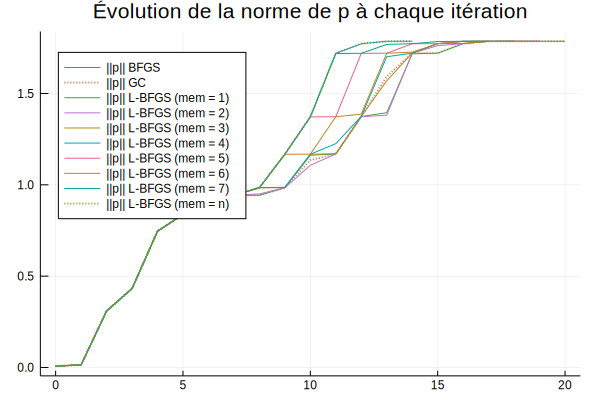

In [8]:
plot(0:iter₂, NormP₂, label = "||p|| BFGS")
plot!(0:(iterᵧ), NormPᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:iter₁, NormP₁, label = "||p|| L-BFGS (mem = 1)")
plot!(0:iter₄, NormP₄, label = "||p|| L-BFGS (mem = 2)")
plot!(0:iter₃, NormP₃, label = "||p|| L-BFGS (mem = 3)")
plot!(0:iter, NormP, label = "||p|| L-BFGS (mem = 4)", legend = :topleft, title = "Évolution de la norme de p à chaque itération")
plot!(0:iter₅, NormP₅, label = "||p|| L-BFGS (mem = 5)")
plot!(0:iter₆, NormP₆, label = "||p|| L-BFGS (mem = 6)")
plot!(0:iter₇, NormP₇, label = "||p|| L-BFGS (mem = 7)")
plot!(0:iter₈, NormP₈, label = "||p|| L-BFGS (mem = n)", line = :dot, lw = 2)

In [84]:
m = 10
@time p₆, NormP₆, iter₆, F₆, α₆, G₆, orthogo₆, P = LMlineSearch(quadratic, x₀, Δ, mem = m, maxiter = itmax, ϵ = 1.0e-06, update = BFGS, negCurvature = nC, affichage = aff);

   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||    ||gₖ||        ρₖ 
   0  4.3e+10 -1.2e+05  2.8e-06 -1.6e-01  9.5e-04  3.4e+02      Inf 
   1  3.8e+10 -1.1e+05  2.8e-06 -3.1e-01  2.0e-03  3.3e+02 -7.2e+16 
   2  3.8e+10 -1.1e+05  2.9e-06 -4.7e-01  3.5e-03  3.3e+02  3.8e+16 
   3  4.0e+10 -1.1e+05  2.8e-06 -6.3e-01  5.1e-03  3.3e+02  4.8e+16 
   4  2.8e+10 -8.9e+04  3.1e-06 -7.7e-01  6.7e-03  3.0e+02  1.2e+16 
   5  2.9e+10 -9.4e+04  3.3e-06 -9.2e-01  8.7e-03  3.1e+02 -3.6e+16 
   6  3.5e+10 -1.0e+05  2.9e-06 -1.1e+00  1.1e-02  3.2e+02  6.4e+16 
   7  2.5e+10 -9.2e+04  3.6e-06 -1.2e+00  1.3e-02  3.0e+02 -1.2e+16 
   8  3.0e+10 -1.0e+05  3.3e-06 -1.4e+00  1.6e-02  3.2e+02  1.5e+16 
   9  3.8e+10 -1.1e+05  2.9e-06 -1.6e+00  1.9e-02  3.3e+02  5.2e+16 
  10  3.1e+10 -1.0e+05  3.3e-06 -1.7e+00  2.2e-02  3.2e+02 -1.4e+17 
  11  4.0e+10 -1.1e+05  2.7e-06 -1.9e+00  2.5e-02  3.3e+02  5.8e+16 
  12  2.6e+10 -8.6e+04  3.3e-06 -2.0e+00  2.7e-02  2.9e+02  2.4e+16 
  13  3.1e+10 -9.8e+04  3.1e-0

 119  1.1e+10 -3.9e+04  3.7e-06 -1.2e+01  5.2e-01  2.0e+02  7.2e+16 
 120  1.4e+10 -4.3e+04  3.1e-06 -1.2e+01  5.2e-01  2.1e+02 -2.6e+16 
 121  1.8e+10 -4.7e+04  2.7e-06 -1.2e+01  5.3e-01  2.2e+02  2.6e+16 
 122  1.1e+10 -3.9e+04  3.7e-06 -1.2e+01  5.3e-01  2.0e+02 -2.9e+16 
 123  1.2e+10 -3.9e+04  3.3e-06 -1.2e+01  5.4e-01  2.0e+02  1.3e+16 
 124  1.0e+10 -3.3e+04  3.3e-06 -1.2e+01  5.4e-01  1.8e+02 -7.2e+16 
 125  1.6e+10 -4.1e+04  2.5e-06 -1.2e+01  5.4e-01  2.0e+02  5.8e+17 
 126  1.2e+10 -4.1e+04  3.5e-06 -1.3e+01  5.5e-01  2.0e+02 -1.8e+16 
 127  1.0e+10 -4.0e+04  4.0e-06 -1.3e+01  5.6e-01  2.0e+02  4.8e+16 
 128  9.3e+09 -3.9e+04  4.2e-06 -1.3e+01  5.6e-01  2.0e+02 -3.6e+16 
 129  1.2e+10 -4.7e+04  4.0e-06 -1.3e+01  5.7e-01  2.2e+02  1.4e+17 
 130  1.1e+10 -5.1e+04  4.6e-06 -1.3e+01  5.8e-01  2.2e+02      Inf 
 131  1.5e+10 -5.4e+04  3.6e-06 -1.3e+01  5.9e-01  2.3e+02 -2.1e+16 
 132  1.7e+10 -5.2e+04  3.1e-06 -1.3e+01  6.0e-01  2.3e+02 -7.2e+16 
 133  1.9e+10 -5.8e+04  3.0e-06 -1

 240  1.6e+10 -6.0e+04  3.7e-06 -2.3e+01  1.7e+00  2.5e+02      Inf 
 241  2.4e+10 -7.8e+04  3.2e-06 -2.3e+01  1.7e+00  2.8e+02 -2.9e+16 
 242  1.6e+10 -5.8e+04  3.7e-06 -2.3e+01  1.7e+00  2.4e+02      Inf 
 243  1.9e+10 -6.6e+04  3.4e-06 -2.4e+01  1.8e+00  2.6e+02 -9.0e+15 
 244  2.7e+10 -8.9e+04  3.3e-06 -2.4e+01  1.8e+00  3.0e+02  7.6e+15 
 245  2.1e+10 -6.8e+04  3.3e-06 -2.4e+01  1.8e+00  2.6e+02 -1.8e+16 
 246  2.8e+10 -7.4e+04  2.7e-06 -2.4e+01  1.8e+00  2.7e+02  1.8e+16 
 247  2.5e+10 -7.9e+04  3.1e-06 -2.4e+01  1.8e+00  2.8e+02  1.4e+17 
 248  2.6e+10 -7.8e+04  3.0e-06 -2.4e+01  1.8e+00  2.8e+02 -1.2e+16 
 249  1.8e+10 -7.0e+04  3.9e-06 -2.4e+01  1.8e+00  2.7e+02  1.2e+16 
 250  1.5e+10 -6.5e+04  4.4e-06 -2.4e+01  1.9e+00  2.5e+02 -1.8e+16 
 251  1.3e+10 -5.9e+04  4.4e-06 -2.5e+01  1.9e+00  2.4e+02  1.3e+16 
 252  2.7e+10 -8.6e+04  3.2e-06 -2.5e+01  1.9e+00  2.9e+02  4.5e+15 
 253  1.6e+10 -6.9e+04  4.2e-06 -2.5e+01  1.9e+00  2.6e+02  1.8e+16 
 254  2.5e+10 -8.8e+04  3.5e-06 -2

 360  4.7e+09 -1.2e+04  2.6e-06 -2.9e+01  2.5e+00  1.1e+02 -1.2e+18 
 361  1.9e+09 -8.4e+03  4.4e-06 -2.9e+01  2.5e+00  9.2e+01  8.2e+16 
 362  4.6e+09 -1.4e+04  2.9e-06 -2.9e+01  2.5e+00  1.2e+02 -2.9e+17 
 363  2.1e+09 -9.2e+03  4.3e-06 -2.9e+01  2.5e+00  9.6e+01  1.4e+17 
 364  3.8e+09 -1.1e+04  2.9e-06 -2.9e+01  2.5e+00  1.0e+02  5.8e+17 
 365  2.3e+09 -1.1e+04  4.8e-06 -2.9e+01  2.5e+00  1.1e+02      Inf 
 366  1.6e+09 -9.9e+03  6.2e-06 -2.9e+01  2.5e+00  9.9e+01  4.1e+16 
 367  5.0e+09 -1.4e+04  2.9e-06 -2.9e+01  2.5e+00  1.2e+02  9.6e+16 
 368  5.1e+09 -1.6e+04  3.2e-06 -2.9e+01  2.5e+00  1.3e+02 -7.2e+16 
 369  6.3e+09 -1.7e+04  2.8e-06 -2.9e+01  2.5e+00  1.3e+02 -4.8e+16 
 370  2.6e+09 -1.0e+04  4.0e-06 -2.9e+01  2.5e+00  1.0e+02  5.8e+17 
 371  6.1e+09 -1.3e+04  2.2e-06 -2.9e+01  2.5e+00  1.1e+02  5.8e+16 
 372  2.0e+09 -8.6e+03  4.3e-06 -2.9e+01  2.5e+00  9.3e+01 -1.4e+17 
 373  1.6e+09 -6.3e+03  3.9e-06 -2.9e+01  2.5e+00  8.0e+01 -1.9e+17 
 374  1.5e+09 -7.6e+03  5.0e-06 -2

 478  2.9e+09 -7.7e+03  2.7e-06 -3.1e+01  2.8e+00  8.8e+01      Inf 
 479  1.5e+09 -4.6e+03  3.0e-06 -3.1e+01  2.8e+00  6.8e+01  5.8e+17 
 480  1.0e+09 -4.6e+03  4.6e-06 -3.1e+01  2.8e+00  6.8e+01 -1.2e+18 
 481  2.2e+09 -5.3e+03  2.5e-06 -3.1e+01  2.8e+00  7.3e+01  3.8e+17 
 482  4.5e+08 -2.5e+03  5.5e-06 -3.1e+01  2.8e+00  5.0e+01  5.8e+17 
 483  1.9e+09 -5.1e+03  2.7e-06 -3.1e+01  2.8e+00  7.2e+01  3.3e+17 
 484  8.0e+08 -2.6e+03  3.3e-06 -3.1e+01  2.8e+00  5.1e+01  2.3e+18 
 485  4.4e+08 -2.3e+03  5.1e-06 -3.1e+01  2.8e+00  4.7e+01  5.8e+17 
 486  1.2e+09 -2.7e+03  2.1e-06 -3.1e+01  2.8e+00  5.2e+01  1.2e+18 
 487  3.5e+08 -1.9e+03  5.5e-06 -3.1e+01  2.8e+00  4.4e+01  5.8e+17 
 488  9.7e+08 -2.8e+03  2.9e-06 -3.1e+01  2.8e+00  5.3e+01 -3.8e+17 
 489  5.3e+08 -1.8e+03  3.4e-06 -3.1e+01  2.8e+00  4.2e+01  9.2e+17 
 490  7.6e+08 -2.3e+03  3.0e-06 -3.1e+01  2.8e+00  4.8e+01      Inf 
 491  5.5e+08 -1.3e+03  2.3e-06 -3.1e+01  2.8e+00  3.6e+01 -3.1e+18 
 492  2.2e+08 -9.9e+02  4.5e-06 -3

 596  3.8e+09 -2.2e+04  5.7e-06 -3.3e+01  3.4e+00  1.5e+02      Inf 
 597  2.0e+10 -4.0e+04  2.0e-06 -3.3e+01  3.4e+00  2.0e+02      Inf 
 598  4.8e+09 -1.7e+04  3.5e-06 -3.3e+01  3.4e+00  1.3e+02 -3.6e+16 
 599  3.7e+09 -1.8e+04  4.9e-06 -3.4e+01  3.4e+00  1.3e+02 -3.6e+16 
 600  8.9e+09 -3.6e+04  4.0e-06 -3.4e+01  3.5e+00  1.9e+02 -1.2e+16 
 601  1.6e+10 -3.7e+04  2.3e-06 -3.4e+01  3.5e+00  1.9e+02  3.6e+16 
 602  5.5e+09 -2.5e+04  4.6e-06 -3.4e+01  3.5e+00  1.6e+02 -1.2e+16 
 603  1.9e+10 -5.1e+04  2.7e-06 -3.4e+01  3.5e+00  2.3e+02 -9.0e+15 
 604  2.0e+10 -5.4e+04  2.7e-06 -3.4e+01  3.5e+00  2.3e+02  6.0e+15 
 605  3.4e+09 -1.5e+04  4.2e-06 -3.4e+01  3.6e+00  1.2e+02      Inf 
 606  3.4e+09 -1.8e+04  5.2e-06 -3.4e+01  3.6e+00  1.3e+02  3.6e+16 
 607  8.2e+09 -2.7e+04  3.3e-06 -3.4e+01  3.6e+00  1.6e+02 -3.6e+16 
 608  5.0e+09 -1.5e+04  3.0e-06 -3.4e+01  3.6e+00  1.2e+02  2.1e+16 
 609  3.9e+09 -1.6e+04  4.0e-06 -3.4e+01  3.6e+00  1.3e+02 -7.2e+16 
 610  3.7e+09 -1.5e+04  4.0e-06 -3

 715  1.8e+03 -3.5e-03  2.0e-06 -3.5e+01  4.1e+00  5.9e-02  1.5e+23 
 716  5.5e+02 -1.3e-03  2.3e-06 -3.5e+01  4.1e+00  3.6e-02  1.4e+23 
 717  2.4e+02 -4.0e-04  1.6e-06 -3.5e+01  4.1e+00  2.0e-02 -2.2e+23 
 718  6.7e+01 -1.3e-04  2.0e-06 -3.5e+01  4.1e+00  1.2e-02  5.2e+23 
 719  3.4e+01 -5.3e-05  1.6e-06 -3.5e+01  4.1e+00  7.3e-03 -8.3e+23 
 720  4.7e+00 -1.3e-05  2.7e-06 -3.5e+01  4.1e+00  3.6e-03  6.8e+23 
 721  2.5e+00 -4.9e-06  1.9e-06 -3.5e+01  4.1e+00  2.2e-03  9.3e+23 
 722  4.7e-01 -1.2e-06  2.6e-06 -3.5e+01  4.1e+00  1.1e-03  3.3e+25 
 723  1.8e-01 -4.3e-07  2.4e-06 -3.5e+01  4.1e+00  6.5e-04 -7.7e+24 
 724  7.1e-02 -1.8e-07  2.5e-06 -3.5e+01  4.1e+00  4.2e-04 -4.7e+25 
 725  3.8e-02 -7.9e-08  2.1e-06 -3.5e+01  4.1e+00  2.8e-04 -1.9e+25 
 726  1.1e-02 -3.3e-08  2.9e-06 -3.5e+01  4.1e+00  1.8e-04  5.6e+24 
 727  8.8e-03 -1.7e-08  2.0e-06 -3.5e+01  4.1e+00  1.3e-04 -1.3e+25 
 728  3.0e-03 -8.6e-09  2.9e-06 -3.5e+01  4.1e+00  9.3e-05 -1.1e+27 
 729  1.4e-03 -4.1e-09  2.8e-06 -3

In [91]:
l = []
for M in m:10:400
    K = length(P[1,:])
    s = []
    for k in 1:(K-M)
        p = P[:, k:(k+M)]
        U = p'*A*p
        D = Diagonal(U[diagind(U)])
        for i = 1:(M+1)
            for j = 1:i
                U[i, j] = 0
            end
        end
        S = inv(D + U)*U
        push!(s, norm(S))
    end
    push!(l, norm(s, Inf))
end

In [102]:
l = []
for m in [3, 5, 10, 20, 40, 100]
    @time p₆, NormP₆, iter₆, F₆, α₆, G₆, orthogo₆, P = LMlineSearch(quadratic, x₀, Δ, mem = m, maxiter = itmax, ϵ = 1.0e-06, update = BFGS, negCurvature = nC, affichage = false);
    K = length(P[1,:])
    s = []
    for k in 1:(K-m)
        p = P[:, k:(k+m)]
        U = p'*A*p
        D = Diagonal(U[diagind(U)])
        for i = 1:(m+1)
            for j = 1:i
                U[i, j] = 0
            end
        end
        S = inv(D + U)*U
        push!(s, norm(S))
    end
    push!(l, norm(s, Inf))
end

 12.589084 seconds (17.27 M allocations: 6.993 GiB, 9.37% gc time)
 14.871913 seconds (17.47 M allocations: 7.066 GiB, 8.96% gc time)
 14.432178 seconds (17.70 M allocations: 7.207 GiB, 10.94% gc time)
 11.929589 seconds (17.83 M allocations: 7.433 GiB, 9.95% gc time)
 12.440533 seconds (17.58 M allocations: 7.789 GiB, 9.61% gc time)
 12.571746 seconds (16.50 M allocations: 8.704 GiB, 10.55% gc time)


In [ ]:
M = 300
@time p₆, NormP₆, iter₆, F₆, α₆, G₆, orthogo₆, P = LMlineSearch(quadratic, x₀, Δ, mem = M, maxiter = itmax, ϵ = 1.0e-06, update = BFGS, negCurvature = nC, affichage = false);
K = length(P[1,:])
s = []
for k in 1:(K-M)
    p = P[:, k:(k+M)]
    U = p'*A*p
    D = Diagonal(U[diagind(U)])
    for i = 1:(M+1)
        for j = 1:i
            U[i, j] = 0
        end
    end
    S = inv(D + U)*U
    push!(s, norm(S))
end

In [107]:
norm(s, Inf)

96.98570526893943

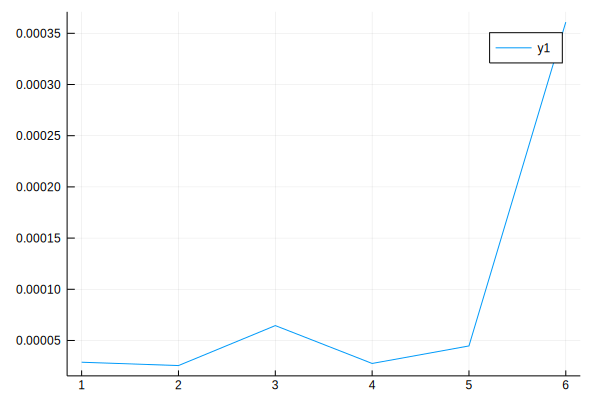

In [103]:
plot(1:6, l)

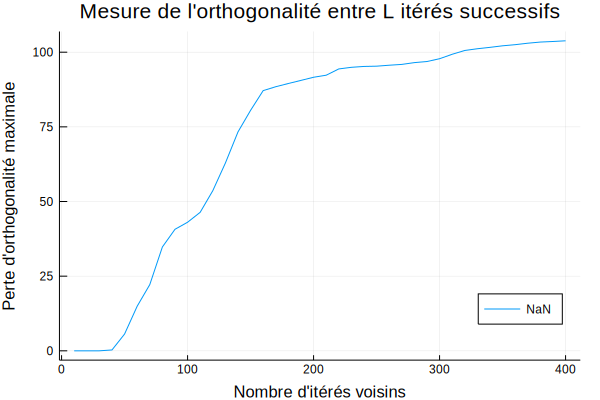

In [101]:
plot(m:10:400, l, title = "Mesure de l'orthogonalité entre L itérés successifs", label = NaN, legend = :bottomright, xlabel = "Nombre d'itérés voisins", ylabel = "Perte d'orthogonalité maximale")

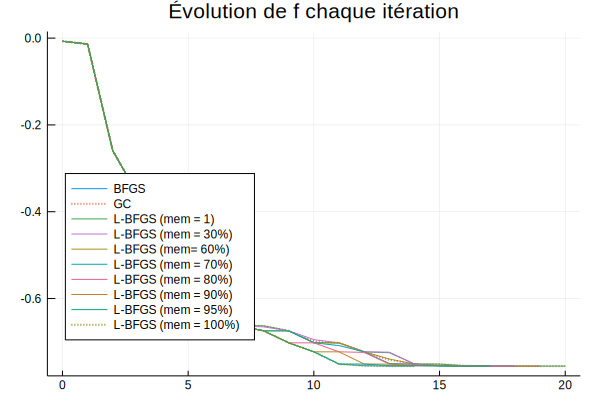

In [25]:
plot(0:iter₂, F₂, label = "BFGS")
plot!(0:(iterᵧ), Fᵧ, label = "GC", lw = 2, line = :dot)
plot!(0:iter₁, F₁, label = "L-BFGS (mem = 1)")
plot!(0:iter₄, F₄, label = "L-BFGS (mem = 30%)")
plot!(0:iter₃, F₃, label = "L-BFGS (mem= 60%)")
plot!(0:iter, F, label = "L-BFGS (mem = 70%)", title = "Évolution de f chaque itération", legend = :bottomleft)
plot!(0:iter₆, F₆, label = "L-BFGS (mem = 80%)")
plot!(0:iter₅, F₅, label = "L-BFGS (mem = 90%)")
plot!(0:iter₇, F₇, label = "L-BFGS (mem = 95%)")
plot!(0:iter₈, F₈, label = "L-BFGS (mem = 100%)", lw = 2, line = :dot)

400-element Array{Float64,1}:
 -0.06937985086928306  
  0.006780250966238256 
  0.009826059963126101 
  0.004730025980303451 
 -0.02044779398327144  
 -0.04697392404844967  
  0.039687892972943555 
  0.05973263998063441  
 -0.07356464884523219  
  0.02325183541943064  
 -0.13414144977341577  
 -0.08189683806478207  
  0.008570809218375535 
  ⋮                    
  0.0029379652876213853
 -0.026096098590425894 
 -0.002400566541907682 
  0.01923946563897437  
  0.021278567485103934 
  0.07046676105602176  
  0.012473424949909799 
 -0.0028224523670683853
 -0.050451880984800745 
 -0.006827427833210229 
 -0.009079391918921776 
 -0.023181645253974315 

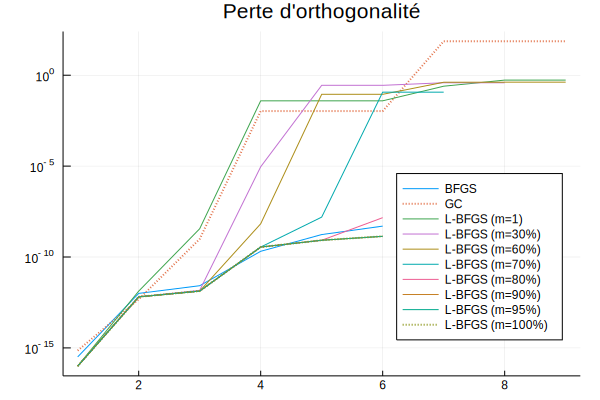

In [80]:
plot(1:iter₂, orthogo₂, label = "BFGS", title = "Perte d'orthogonalité", yaxis = :log, legend = :bottomright)
plot!(1:(iterᵧ), orthogoᵧ, label = "GC", lw = 2, line = :dot)
plot!(1:iter₁, orthogo₁, label = "L-BFGS (m=1)")
plot!(1:iter₄, orthogo₄, label = "L-BFGS (m=30%)")
plot!(1:iter₃, orthogo₃, label = "L-BFGS (m=60%)")
plot!(1:iter, orthogo, label = "L-BFGS (m=70%)")
plot!(1:iter₆, orthogo₆, label = "L-BFGS (m=80%)")
plot!(1:iter₅, orthogo₅, label = "L-BFGS (m=90%)")
plot!(1:iter₇, orthogo₇, label = "L-BFGS (m=95%)")
plot!(1:iter₈, orthogo₈, label = "L-BFGS (m=100%)", lw = 2, line = :dot)

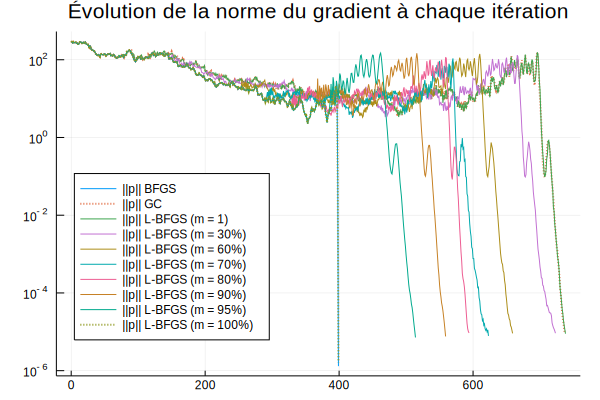

In [278]:
plot(0:(iter₂), G₂, label = "||p|| BFGS", title = "Évolution de la norme du gradient à chaque itération", yaxis = :log, legend = :bottomleft)
plot!(0:(iterᵧ), Gᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:(iter₁), G₁, label = "||p|| L-BFGS (m = 1)")
plot!(0:(iter₄), G₄, label = "||p|| L-BFGS (m = 30%)")
plot!(0:(iter₃), G₃, label = "||p|| L-BFGS (m = 60%)")
plot!(0:(iter), G, label = "||p|| L-BFGS (m = 70%)")
plot!(0:(iter₆), G₆, label = "||p|| L-BFGS (m = 80%)")
plot!(0:(iter₅), G₅, label = "||p|| L-BFGS (m = 90%)")
plot!(0:(iter₇), G₇, label = "||p|| L-BFGS (m = 95%)")
plot!(0:(iter₈), G₈, label = "||p|| L-BFGS (m = 100%)", lw = 2, line = :dot)

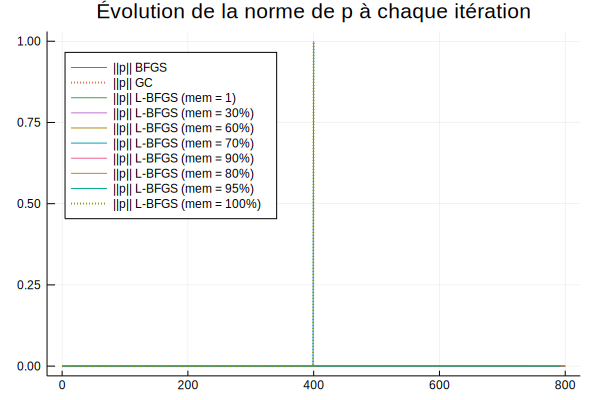

In [287]:
plot(0:iter₂, α₂, label = "||p|| BFGS")
plot!(0:(iterᵧ), αᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:iter₁, α₁, label = "||p|| L-BFGS (mem = 1)")
plot!(0:iter₄, α₄, label = "||p|| L-BFGS (mem = 30%)")
plot!(0:iter₃, α₃, label = "||p|| L-BFGS (mem = 60%)")
plot!(0:iter, α, label = "||p|| L-BFGS (mem = 70%)", legend = :topleft, title = "Évolution de la norme de p à chaque itération")
plot!(0:iter₅, α₅, label = "||p|| L-BFGS (mem = 90%)")
plot!(0:iter₆, α₆, label = "||p|| L-BFGS (mem = 80%)")
plot!(0:iter₇, α₇, label = "||p|| L-BFGS (mem = 95%)")
plot!(0:iter₈, α₈, label = "||p|| L-BFGS (mem = 100%)", line = :dot, lw = 2)

In [180]:
# Δ_ Hyperparamètre (taille maximale de la région de confiance)
# η < μ : Hyperparamètres désignant si on a une bonne approximation de la fonction objectif
# itermax : Hyperparamètre (nombre d'itérations maximal)
# x₀ : point initial
# approximateX : méthode d'approximation de xₖ
# pb : objet de classe problem contenant les données du problème (f, ∇f, ∇²f)
# ϵ : tolérance d'arrêt (à valeur de zéro)
function TrustRegion(x₀, pb; mem = 5, LS = linesearch, affichage = true, itermax = 1000, Δ_ = 3., μ = 1/4, η = 1/5, ϵ = 10e-6)
    N = length(x₀)
    # Initialisation
    Δ = Δ_/2
    xₖ = x₀
    fₖ = pb.fonction(xₖ)
    gₖ = pb.gradient(xₖ)
    Aₖ = pb.Hess(xₖ)
    O = zeros(N)
    # Aₖp = diff(pb.gradient, xₖ, p)
    pred(p) = - (dot(p, gₖ) + 0.5*dot(p, Aₖ*p))
    k = 0
    δ = []
    normX = []
    F = []
    G = []
    while(k < itermax && norm(gₖ) > ϵ)
        ∇m(x) = gₖ + Aₖ*x
        m(x) = fₖ + dot(gₖ, x) + 0.5*dot(x , Aₖ*x)
        ∇²m(x) = pb.Hess(xₖ)
        model = problem(m, ∇m, ∇²m)
        p, a, b, c, d, e, z = LS(model, O, Δ, mem = mem) # Recherche du pas optimal du sous-problème (SP2)
        ρ = (fₖ - pb.fonction(xₖ + p))/pred(p) # Ratio de confiance
        # Mise à jour du rayon de la région de confiance
        if(ρ < μ) # Mauvaise approximation : on réduit le rayon
            Δ = Δ/4
        elseif(ρ > 1 - μ && Δ - ϵ < norm(p) < Δ + ϵ) # Très bonne approximation : on agrandit le rayon
            Δ = min(2*Δ, Δ_)
        end
        # Mise à jour du point courant
        if(ρ > η) # Si bonne approximation de f alors faire une mise à jour
            xₖ += p
            fₖ = pb.fonction(xₖ)
            gₖ = pb.gradient(xₖ)
            Aₖ = pb.Hess(xₖ)
        end
        k += 1
        println("Itération n°$k de TS :")
        a = norm(gₖ)
        println("f = $fₖ, ||g|| = $a, Δ = $Δ")
        push!(δ, Δ)
        push!(normX, norm(xₖ))
        push!(G, norm(gₖ))
        push!(F, fₖ)
    end
    return(xₖ, k, normX, F, G, δ)
end

TrustRegion (generic function with 1 method)

In [193]:
xₖ, k, normX, F, G, δ = TrustRegion(x₀, quadratic, LS = LMlineSearch, Δ_ = 2, mem = 5);

   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||    ||gₖ||        ρₖ 
   0  1.4e+03 -4.2e+00  2.9e-03 -6.1e-03  6.0e-03  2.0e+00      Inf 
   1  3.1e+04 -1.5e+01  4.9e-04 -9.9e-03  9.9e-03  3.9e+00  7.9e+18 
   2  2.5e+02 -1.1e+01  4.4e-02 -2.6e-01  3.2e-01  3.3e+00  1.8e+16 
   3  1.6e+02 -3.3e+00  2.1e-02 -2.9e-01  3.6e-01  1.8e+00 -1.0e+17 
   4  8.4e+02 -1.4e+01  1.6e-02 -4.0e-01  5.3e-01  3.7e+00 -9.6e+16 
   5  4.3e+00 -7.7e-01  1.8e-01 -4.7e-01  6.7e-01  8.8e-01  6.7e+15 
   6  1.5e+00 -4.3e-01  3.0e-01 -5.4e-01  8.4e-01  6.6e-01 -2.6e+15 
   7  2.6e+00 -4.9e-01  1.9e-01 -5.9e-01  1.0e+00  7.0e-01  2.9e+15 
   8  3.8e-01 -1.6e-01  4.3e-01 -6.2e-01  1.1e+00  4.0e-01 -1.1e+15 
sortie de la région de confiance :  f(x*) =  -5.9e-01 ||p*|| =   1.0e+00 
Itération n°1 de TS :
f = -0.5872474908674188, ||g|| = 0.39047811486754214, Δ = 2.0
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||    ||gₖ||        ρₖ 
   0  6.0e-01 -1.5e-01  2.5e-01 -6.1e-01  1.0e-01  3.9e-01      Inf 
   1  

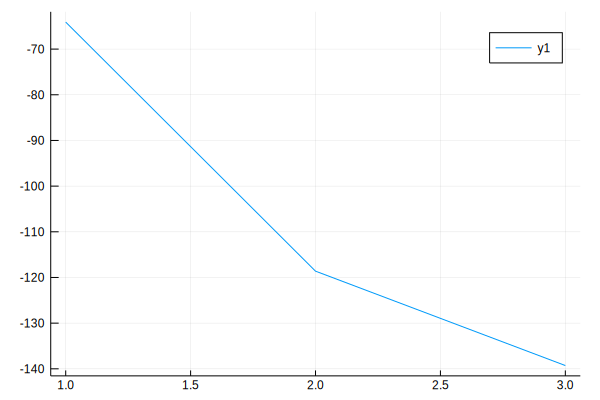

In [161]:
plot(1:k , F)

In [16]:
N = 6
d = [1, 2, 3, 4, 3, 6] # Exemple normal (cas particulier, 1 déjà présent dans la matrice de départ)
N, d = 15, [1, 9, 8, 5, 3e2, 3.4, 2, 1.33, 13, 20, 4.4e3, 7e2, 2.9, 0.1, 1.2]

# Construction d'une matrice symétrique de la forme QᵗDQ
D = Diagonal(d)  
eigvals(D)
A = rand(N, N)
Q, R = qr(A) #
A = transpose(Q)*D*Q
b = rand(N)

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(N)
quadratic = problem(f, g, B)
norm(inv(A))*norm(A)

45274.08709449825

In [18]:
using LinearOperators
println("Méthode L-BFGS")
@time p₇, NormP₇, iter₇, F₇, α₇, G₇, orthogo₇ = LMlineSearch(quadratic, x₀, Inf, mem = 3, affichage = true, scaling = true);

Méthode L-BFGS
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||    ||gₖ||        ρₖ 
   0  4.9e+03 -5.9e+00  1.2e-03 -3.5e-03  2.9e-03  2.4e+00      Inf 
   1  5.1e-08 -4.2e-05  8.1e+02 -2.0e-02  2.3e-02  4.9e+00  4.7e+14 
   2  4.7e-06 -1.7e-03  3.7e+02 -3.4e-01  4.0e-01  5.4e+00  4.8e+12 
   3  4.5e-01 -2.3e-01  5.2e-01 -4.0e-01  4.6e-01  5.1e+00 -9.6e+14 
   4  6.7e-02 -4.8e-02  7.2e-01 -4.2e-01  4.7e-01  3.9e+00 -5.4e+15 
   5  1.8e-03 -1.7e-02  9.4e+00 -5.0e-01  5.1e-01  9.7e+00 -6.0e+15 
   6  1.6e-02 -7.7e-02  4.9e+00 -6.9e-01  6.6e-01  9.1e+00  6.1e+14 
   7  3.7e-03 -4.1e-02  1.1e+01 -9.2e-01  8.5e-01  3.2e+00 -6.6e+13 
   8  1.2e+00 -3.0e-01  2.6e-01 -9.6e-01  8.9e-01  5.2e+00  8.2e+15 
   9  8.5e-02 -5.0e-02  5.9e-01 -9.7e-01  9.0e-01  9.7e+00  4.7e+15 
  10  5.5e-04 -2.4e-03  4.4e+00 -9.8e-01  9.1e-01  2.8e+00  4.1e+14 
  11  2.5e-05 -2.7e-03  1.1e+02 -1.1e+00  1.2e+00  1.4e+00 -3.0e+13 
  12  2.1e-01 -1.9e-01  9.1e-01 -1.2e+00  1.3e+00  1.5e+00  3.0e+14 
  13  1.8e+00 -

 122  1.4e-04 -6.0e-04  4.2e+00 -3.5e+00  7.6e+00  2.8e-01 -2.5e+13 
 123  1.4e-03 -2.2e-03  1.5e+00 -3.6e+00  7.6e+00  2.3e+00 -9.6e+14 
 124  1.7e-04 -5.0e-04  2.9e+00 -3.6e+00  7.6e+00  1.0e+00  2.7e+13 
 125  5.5e-05 -2.2e-04  4.0e+00 -3.6e+00  7.6e+00  4.0e-01 -1.6e+14 
 126  1.2e-04 -3.2e-04  2.7e+00 -3.6e+00  7.6e+00  2.5e-01  2.5e+14 
 127  8.7e-04 -7.3e-04  8.4e-01 -3.6e+00  7.6e+00  1.1e+00 -6.2e+14 
 128  1.7e-05 -6.2e-05  3.7e+00 -3.6e+00  7.6e+00  4.1e-01 -6.7e+15 
 129  3.8e-06 -5.4e-05  1.4e+01 -3.6e+00  7.6e+00  2.1e-01 -1.1e+14 
 130  2.5e-04 -6.4e-04  2.6e+00 -3.6e+00  7.6e+00  3.7e-01  1.7e+14 
 131  6.4e-03 -1.5e-03  2.3e-01 -3.6e+00  7.6e+00  1.0e+00 -1.0e+15 
 132  2.4e-06 -2.1e-05  9.0e+00 -3.6e+00  7.6e+00  2.9e-01  3.9e+14 
 133  1.2e-05 -1.1e-04  9.2e+00 -3.6e+00  7.7e+00  2.4e-01  2.0e+14 
 134  2.0e-04 -6.9e-04  3.5e+00 -3.6e+00  7.7e+00  4.0e-01 -6.7e+13 
 135  2.0e-02 -1.8e-03  9.1e-02 -3.6e+00  7.7e+00  7.6e-01  1.5e+15 
 136  6.2e-07 -2.4e-05  3.9e+01 -3

 242  3.5e-09 -1.4e-08  4.1e+00 -3.6e+00  7.4e+00  3.9e-03  6.6e+16 
 243  1.2e-09 -1.9e-08  1.5e+01 -3.6e+00  7.4e+00  2.3e-03 -1.1e+16 
 244  2.4e-06 -2.8e-07  1.2e-01 -3.6e+00  7.4e+00  1.2e-02 -4.7e+17 
 245  3.9e-10 -2.5e-09  6.5e+00 -3.6e+00  7.4e+00  3.3e-03  2.6e+16 
 246  6.5e-10 -6.0e-09  9.3e+00 -3.6e+00  7.4e+00  2.4e-03  1.8e+17 
 247  6.9e-09 -3.7e-08  5.3e+00 -3.6e+00  7.4e+00  3.8e-03 -3.9e+16 
 248  2.4e-06 -1.3e-07  5.4e-02 -3.6e+00  7.4e+00  3.7e-03  7.9e+17 
 249  6.3e-11 -2.4e-09  3.9e+01 -3.6e+00  7.4e+00  2.7e-03 -3.6e+16 
 250  3.5e-08 -7.8e-08  2.2e+00 -3.6e+00  7.4e+00  7.5e-03  3.2e+16 
 251  7.4e-09 -2.0e-08  2.7e+00 -3.6e+00  7.4e+00  3.0e-03  1.5e+16 
 252  1.6e-08 -2.7e-08  1.7e+00 -3.6e+00  7.4e+00  2.1e-03 -3.0e+16 
 253  4.6e-09 -3.4e-08  7.5e+00 -3.6e+00  7.4e+00  1.2e-02  2.0e+16 
 254  4.6e-08 -3.4e-08  7.3e-01 -3.6e+00  7.4e+00  4.1e-03 -2.3e+16 
 255  1.1e-10 -3.7e-09  3.2e+01 -3.6e+00  7.4e+00  1.7e-03  5.1e+15 
 256  2.1e-07 -1.0e-07  4.7e-01 -3

 479  6.0e-16 -5.7e-15  9.5e+00 -3.6e+00  7.4e+00  5.3e-06  5.0e+19 
 480  1.6e-15 -2.6e-14  1.7e+01 -3.6e+00  7.4e+00  4.5e-06 -1.4e+19 
 481  2.2e-13 -2.8e-13  1.3e+00 -3.6e+00  7.4e+00  7.2e-06 -4.1e+19 
 482  1.8e-12 -1.6e-13  9.0e-02 -3.6e+00  7.4e+00  4.3e-06  4.4e+20 
 483  3.3e-16 -6.4e-15  2.0e+01 -3.6e+00  7.4e+00  6.2e-06 -1.6e+20 
 484  1.2e-14 -9.1e-14  7.9e+00 -3.6e+00  7.4e+00  8.8e-06  5.2e+18 
 485  1.1e-13 -2.2e-13  2.0e+00 -3.6e+00  7.4e+00  5.2e-06 -6.5e+18 
 486  6.0e-13 -3.1e-13  5.1e-01 -3.6e+00  7.4e+00  7.8e-06 -4.7e+19 
 487  1.7e-14 -1.1e-13  6.8e+00 -3.6e+00  7.4e+00  2.0e-05  1.2e+19 
 488  1.9e-13 -2.4e-13  1.3e+00 -3.6e+00  7.4e+00  1.3e-05 -9.7e+18 
 489  7.9e-16 -1.5e-14  1.9e+01 -3.6e+00  7.4e+00  2.6e-06 -4.8e+18 
 490  3.1e-13 -2.2e-13  7.1e-01 -3.6e+00  7.4e+00  5.5e-06 -2.2e+20 
 491  2.8e-13 -1.3e-13  4.5e-01 -3.6e+00  7.4e+00  1.3e-05 -6.5e+20 
 492  5.5e-16 -3.6e-15  6.5e+00 -3.6e+00  7.4e+00  2.8e-06 -6.9e+19 
 493  4.6e-16 -1.2e-14  2.5e+01 -3

 598  7.4e-19 -2.7e-17  3.7e+01 -3.6e+00  7.4e+00  3.8e-07 -1.0e+20 
 599  2.9e-16 -5.9e-16  2.0e+00 -3.6e+00  7.4e+00  4.3e-07  5.9e+20 
 600  1.0e-15 -7.7e-16  7.3e-01 -3.6e+00  7.4e+00  4.0e-07 -6.4e+20 
 601  2.5e-16 -2.3e-16  9.1e-01 -3.6e+00  7.4e+00  3.4e-07 -4.7e+21 
 602  6.3e-18 -1.2e-16  2.0e+01 -3.6e+00  7.4e+00  7.8e-07 -2.9e+20 
 603  2.7e-16 -4.0e-16  1.5e+00 -3.6e+00  7.4e+00  2.9e-07  6.4e+19 
 604  3.5e-16 -3.1e-16  8.7e-01 -3.6e+00  7.4e+00  2.7e-07 -1.5e+21 
 605  6.5e-17 -1.5e-16  2.3e+00 -3.6e+00  7.4e+00  2.8e-07  4.9e+20 
 606  4.4e-17 -2.4e-16  5.4e+00 -3.6e+00  7.4e+00  1.1e-06 -2.2e+20 
 607  5.4e-18 -1.1e-16  2.0e+01 -3.6e+00  7.4e+00  2.2e-07  1.6e+19 
 608  6.2e-15 -1.5e-15  2.3e-01 -3.6e+00  7.4e+00  3.5e-07 -5.2e+20 
 609  7.7e-17 -1.8e-16  2.3e+00 -3.6e+00  7.4e+00  3.4e-07  1.1e+21 
 610  5.6e-16 -2.9e-16  5.1e-01 -3.6e+00  7.4e+00  6.9e-07  1.0e+22 
 611  1.4e-19 -1.6e-17  1.1e+02 -3.6e+00  7.4e+00  2.0e-07  1.7e+19 
 612  8.3e-16 -9.5e-16  1.1e+00 -3

In [15]:
G₇

13-element Array{Any,1}:
 0.6279401507923904    
 0.3110110127340068    
 0.16443090268831798   
 0.029843428672634988  
 0.006873429150323352  
 0.0009290928186150402 
 0.00031874213580951376
 6.360430160582268e-5  
 7.914954760890759e-6  
 4.774703607242782e-6  
 1.0510302632761236e-6 
 2.781664068837585e-7  
 6.443984519142812e-8  

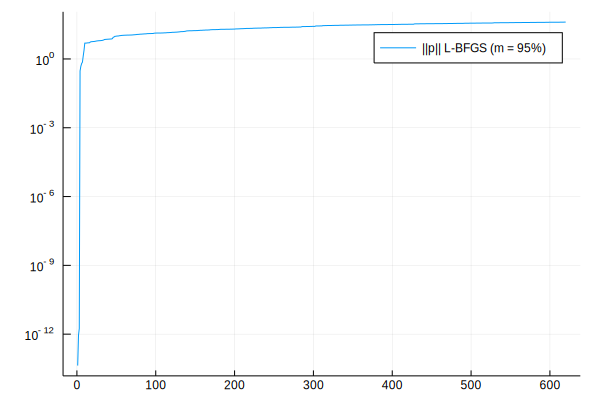

In [19]:
plot(1:(iter₇), orthogo₇, label = "||p|| L-BFGS (m = 95%)", yaxis = :log)

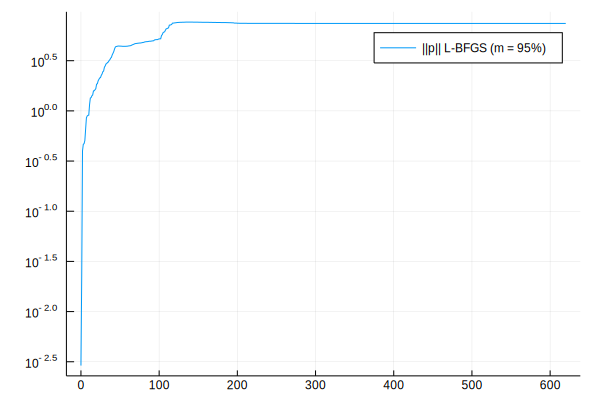

In [20]:
plot(0:(iter₇), NormP₇, label = "||p|| L-BFGS (m = 95%)", yaxis = :log)

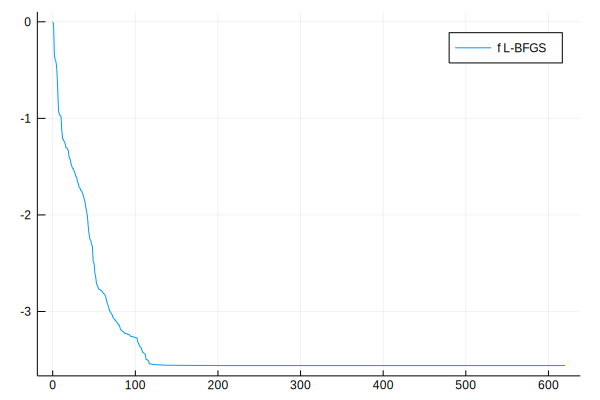

In [21]:
plot(0:(iter₇), F₇, label = "f L-BFGS")